In [1]:
from download_tickers import run_async_download

In [25]:
# might have to import a bunch of stuff here before running the data pull

In [26]:
# run_async_download(freq='1day') # ideally run this by going to terminal and type `python download_tickers.py`

In [5]:
import pandas as pd

def get_history(symbols, start_dt, end_dt, file='./Data/Prices/daily/csv/agg_prices'):
    historical_close = pd.read_csv('{}.csv'.format(file))
    historical_close.as_of_date = pd.to_datetime(historical_close.as_of_date).dt.date
    historical_close = historical_close[historical_close.as_of_date >= pd.to_datetime(start_dt)]
    historical_close = historical_close[historical_close.as_of_date <= pd.to_datetime(end_dt)]
    if len(symbols) > 0:
        historical_close = historical_close[historical_close['ticker'].isin(symbols)]

    historical_close = historical_close.groupby(['as_of_date','ticker']).first()
    mux = pd.MultiIndex.from_product([pd.to_datetime(historical_close.index.levels[0]), historical_close.index.levels[1]],
                                 names=historical_close.index.names)
    historical_close = historical_close.reindex(mux)
    
    historical_close = historical_close[[col for col in historical_close.columns if col == 'close']]
    historical_close = pd.DataFrame(historical_close, index=historical_close.index)

    return historical_close


In [6]:
price_df = get_history(['btcusd'], '2018-01-01','2020-01-01')

/var/folders/vc/_33kv4rn2q9dy8rxcn3yxj980000gn/T/ipykernel_27342/3790196643.py:6: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  historical_close = historical_close[historical_close.as_of_date >= pd.to_datetime(start_dt)]
/var/folders/vc/_33kv4rn2q9dy8rxcn3yxj980000gn/T/ipykernel_27342/3790196643.py:7: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  historical_close = historical_close[historical_close.as_of_date <= pd.to_datetime(end_dt)]


In [7]:
price_df

,,close
as_of_date,ticker,
2018-01-01,btcusd,13880.000000
2018-01-02,btcusd,13443.410000
2018-01-03,btcusd,14678.940000
2018-01-04,btcusd,15155.620000
2018-01-05,btcusd,15143.670000
...,...,...
2019-12-28,btcusd,7315.466457
2019-12-29,btcusd,7389.324292
2019-12-30,btcusd,7241.667479


In [21]:
# seasonality code

In [22]:
import matplotlib.pyplot as plt
from datetime import datetime
from scipy import stats

def plot_seasonality(historical_prices, method_type='weekly', resolution='daily', symbol='btcusd', start_year=2014, end_year=2022):
    start_dt, end_dt = datetime(start_year, 1, 1), datetime(end_year, 1, 1)
    historical_prices = historical_prices.unstack(level=1)
    data_source_df = historical_prices.close.pct_change().dropna(how='all')

    forward_returns = data_source_df.shift(-1).dropna(how='all')
    # cum_ret = (data_source_df + 1).cumprod()

    # lookback = 90
    # signal = (cum_ret - cum_ret.rolling(lookback).mean()) / cum_ret.rolling(lookback).std()
    # final_signal = forward_returns[abs(signal) < 2]
    final_signal = forward_returns
    
    if method_type == 'weekly' and resolution == 'hourly':
        print("doesn't work yet, need to get an hourly data source formatted")
        final_signal['hour'] = (final_signal.index.hour + 1) + (24 * final_signal.index.dayofweek)
        grouped_returns = final_signal.groupby(["hour"])
    if method_type == 'weekly' and resolution == 'daily':
        final_signal["day"] = final_signal.index.day_name()
        grouped_returns = final_signal.groupby(["day"])
    if method_type == 'monthly' and resolution == 'daily':
        final_signal["year"] = final_signal.index.year
        final_signal["month"] = final_signal.index.month
        final_signal["day"] = final_signal.index.day

        print(final_signal)
        final_signal['day'] = final_signal.groupby(["year", "month"])['day'].rank(axis=0)
        final_signal['day'] = final_signal['day'].astype(int)
        final_signal = final_signal.drop(columns=['year','month'])
        grouped_returns = final_signal.groupby(["day"])

    grouped_number_events = grouped_returns.count()
    grouped_average_returns = grouped_returns.agg(lambda x: stats.gmean(x + 1)) - 1
    grouped_average_std = grouped_returns.agg(lambda x: stats.gstd(x + 1)) - 1
    risk_adjusted_returns = (grouped_average_returns / grouped_average_std) * (52 ** 0.5)
    grouped_cumulative_returns = (1 + grouped_average_returns).cumprod() - 1

    if method_type == 'weekly' and resolution == 'hourly':
        xcoords = [24,24*2,24*3,24*4,114]
    
        grouped_cumulative_returns.plot(grid=True, kind='bar', title='Cumulative Hourly Returns Of The Week', figsize=(18, 7))
        for xc in xcoords:
            plt.axvline(x=xc, color='red')
    
        grouped_average_returns.plot(grid=True, kind='bar', title='Hourly Returns Of The Week', figsize=(18, 7))
        for xc in xcoords:
            plt.axvline(x=xc, color='red')
            
        risk_adjusted_returns.plot(grid=True, kind='bar', title='Risk Adjusted Returns Of The Week', figsize=(18, 7))
        for xc in xcoords:
            plt.axvline(x=xc, color='red')

        grouped_number_events.plot(grid=True, kind='bar', title='Number Of Events Per Hour', figsize=(18, 7))
        for xc in xcoords:
            plt.axvline(x=xc, color='red')
            
    if method_type == 'weekly' and resolution == 'daily':
        grouped_cumulative_returns.plot(grid=True, kind='bar', title='Cumulative Daily Returns Of The Week {}, {}'.format(start_year, end_year), figsize=(18, 7))
        
        grouped_average_returns.plot(grid=True, kind='bar', title='Daily Returns Of The Week {}, {}'.format(start_year, end_year), figsize=(18, 7))
                        
        risk_adjusted_returns.plot(grid=True, kind='bar', title='Risk Adjusted Returns Of The Week {}, {}'.format(start_year, end_year), figsize=(18, 7))
            
        grouped_number_events.plot(grid=True, kind='bar', title='Number Of Events Per Day {}, {}'.format(start_year, end_year), figsize=(18, 7))
            
    if method_type == 'monthly' and resolution == 'daily':
        grouped_cumulative_returns.plot(grid=True, kind='bar', title='Cumulative Daily Returns Of The Month {}, {}'.format(start_year, end_year), figsize=(18, 7))
        
        grouped_average_returns.plot(grid=True, kind='bar', title='Daily Returns Of The Month {}, {}'.format(start_year, end_year), figsize=(18, 7))
                        
        risk_adjusted_returns.plot(grid=True, kind='bar', title='Risk Adjusted Returns Of The Month {}, {}'.format(start_year, end_year), figsize=(18, 7))
            
        grouped_number_events.plot(grid=True, kind='bar', title='Number Of Events Per Day {}, {}'.format(start_year, end_year), figsize=(18, 7))
            

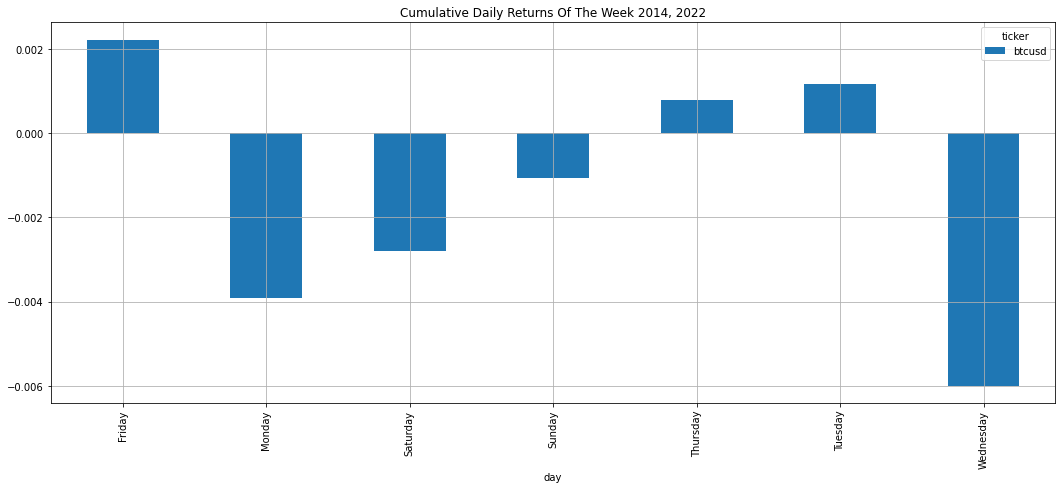

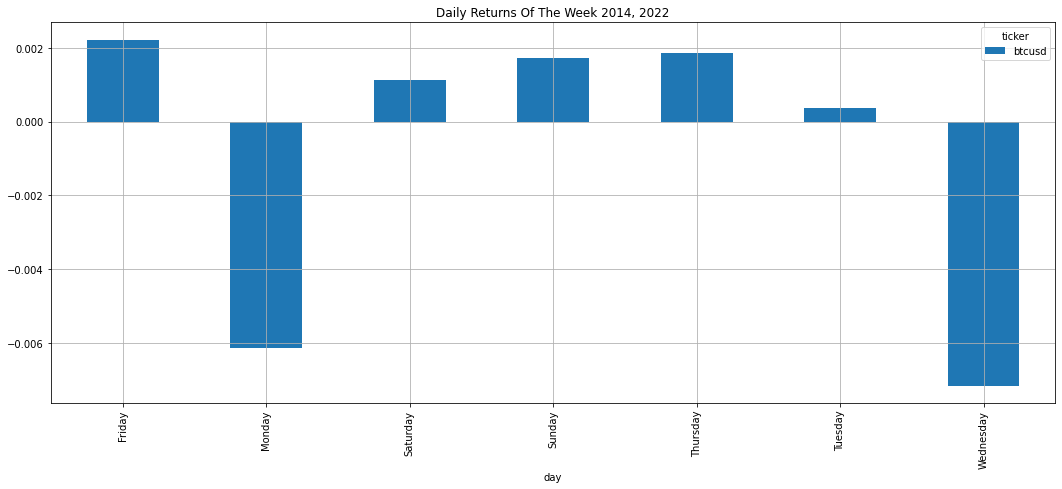

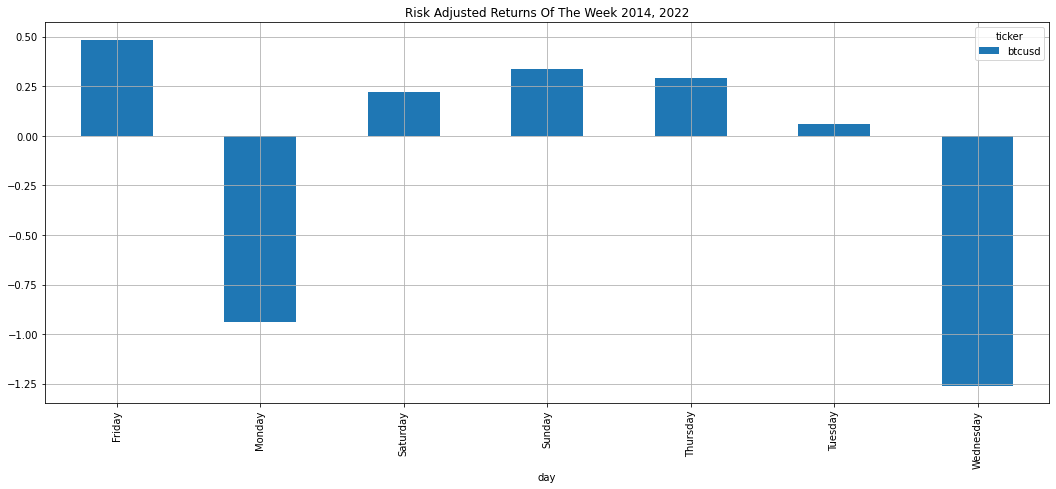

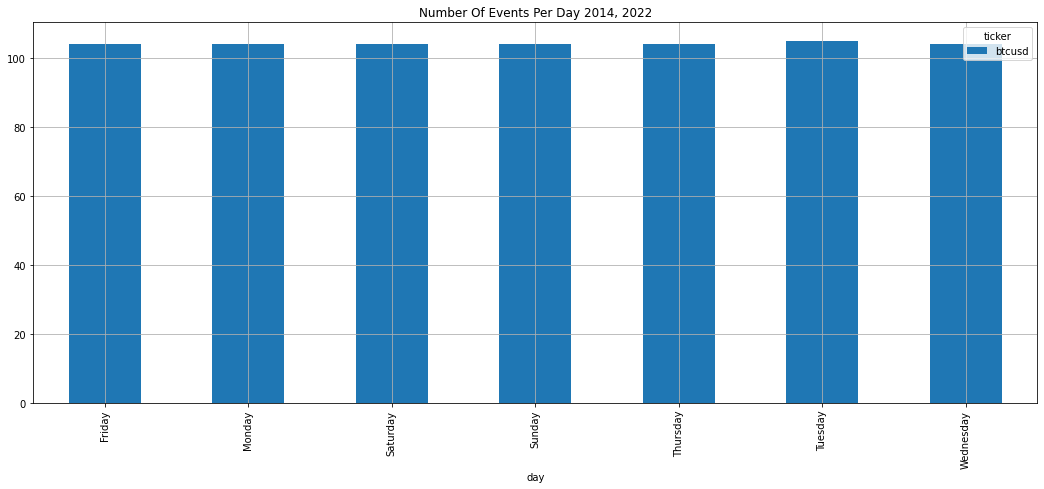

In [23]:
plot_seasonality(price_df, method_type='weekly', resolution='daily',symbol='btcusd', start_year=2014, end_year=2022)

ticker        btcusd  year  month  day
as_of_date                            
2018-01-02  0.091906  2018      1    2
2018-01-03  0.032474  2018      1    3
2018-01-04 -0.000788  2018      1    4
2018-01-05  0.117827  2018      1    5
2018-01-06  0.013095  2018      1    6
...              ...   ...    ...  ...
2019-12-27  0.008241  2019     12   27
2019-12-28  0.010096  2019     12   28
2019-12-29 -0.019982  2019     12   29
2019-12-30 -0.007160  2019     12   30
2019-12-31  0.000968  2019     12   31

[729 rows x 4 columns]


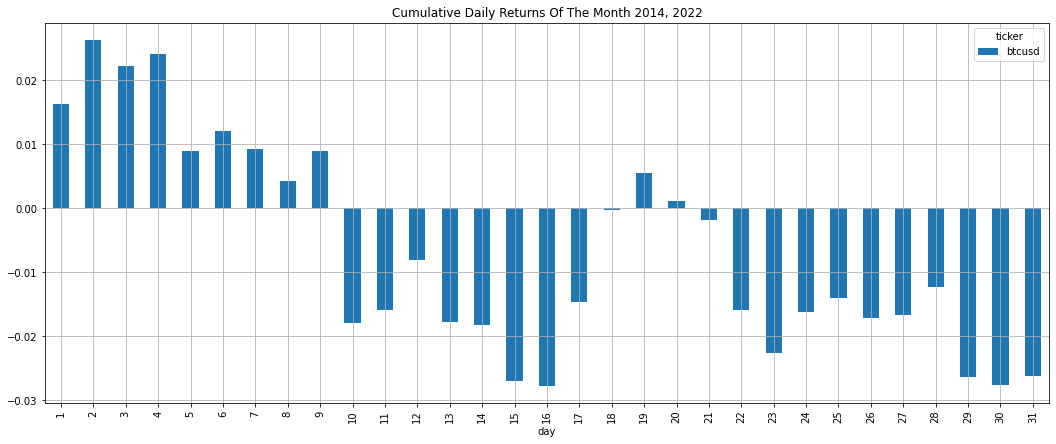

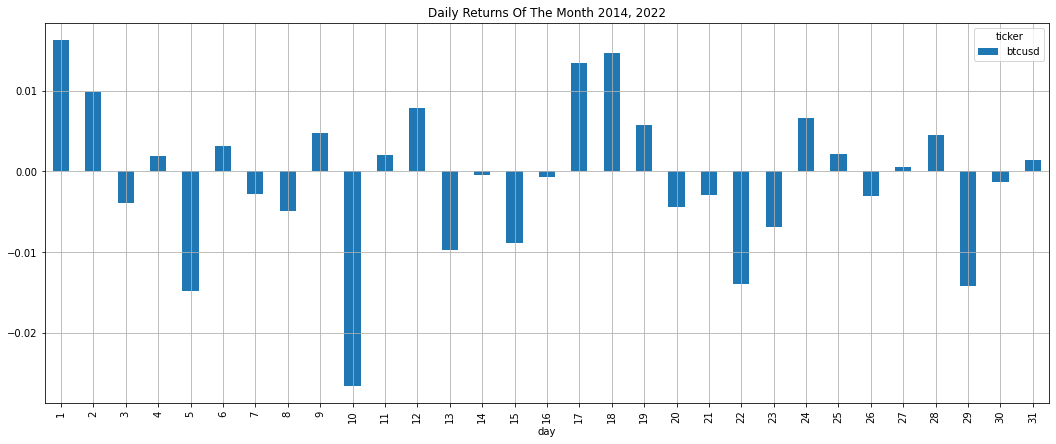

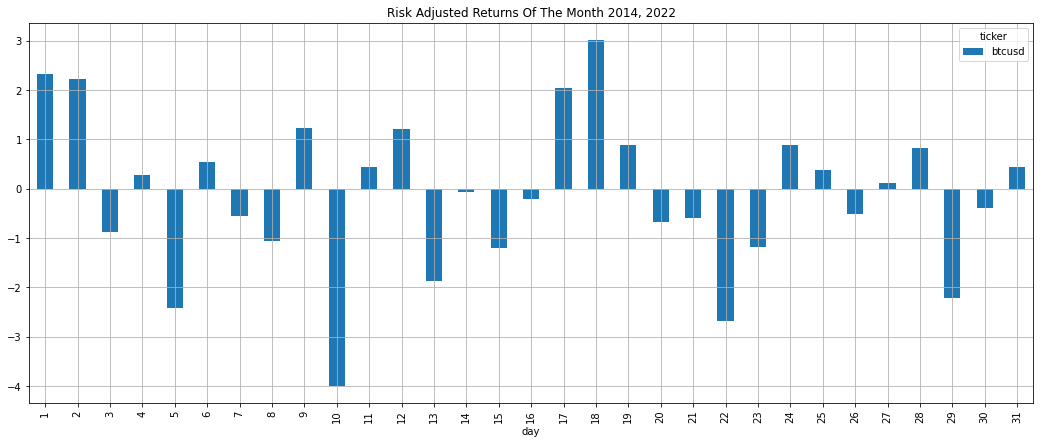

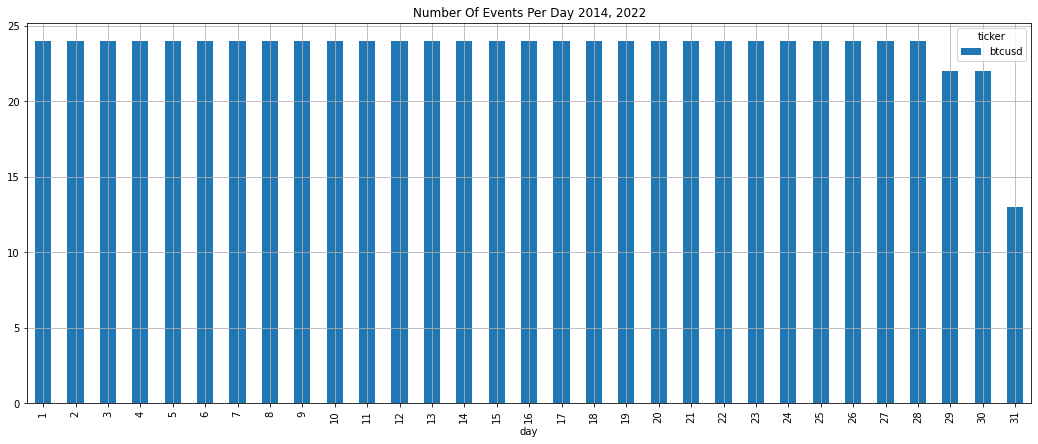

In [24]:
plot_seasonality(price_df, method_type='monthly', resolution='daily',symbol='btcusd', start_year=2014, end_year=2022)